This script aims to extract features out of raw ppg signal that would be useful in analysis of sleep stage of individuals.

In [7]:
import numpy as np
import scipy.stats as stats
from scipy.signal import find_peaks
from scipy.linalg import svd
from statsmodels.robust import mad
import nolds
from scipy.integrate import simps
import pandas as pd

# Load data
data = pd.read_csv("/Users/jasper/Desktop/SIT782/test8.csv", header=None)
data_1 = data[0][0:299]
ppg_signal = np.array([data_1]).flatten()

# Constants
sampling_rate = 100  # in Hz
epoch_duration = len(ppg_signal) / sampling_rate  # in seconds

# Find peaks (simulating pulse peaks)
peaks, _ = find_peaks(ppg_signal)
troughs, _ = find_peaks(-ppg_signal)

# Peak-to-peak intervals (in seconds)
pp_intervals = np.diff(peaks) / sampling_rate

# Feature calculation functions
def rms(x):
    return np.sqrt(np.mean(x**2))

def calculate_sdsd(x):
    return np.std(np.diff(x))

def calculate_rmssd(x):
    return np.sqrt(np.mean(np.diff(x)**2))

def calculate_areas(signal, inflection_indices):
    area_sys = simps(signal[inflection_indices[:len(inflection_indices)//2]], dx=1/sampling_rate)
    area_dias = simps(signal[inflection_indices[len(inflection_indices)//2:]], dx=1/sampling_rate)
    return area_sys, area_dias

def calculate_pulse_width(peaks, troughs, sampling_rate):
    widths = []
    for i in range(len(peaks) - 1):
        if i < len(troughs) and peaks[i] < troughs[i]:
            widths.append((troughs[i] - peaks[i]) / sampling_rate)
    return np.array(widths)

def inflection_points(signal):
    inflections = []
    for i in range(1, len(signal)-1):
        if (signal[i-1] < signal[i] > signal[i+1]) or (signal[i-1] > signal[i] < signal[i+1]):
            inflections.append(i)
    return inflections
    
def higuchi_fd(x, kmax):
    """Calculate Higuchi Fractal Dimension (HFD) of a time series."""
    N = len(x)
    Lk = np.zeros(kmax)

    for k in range(1, kmax + 1):
        Lm = np.zeros((k,))

        for m in range(0, k):
            Lmk = 0
            for i in range(1, int(np.floor((N - m) / k))):
                Lmk += abs(x[m + i * k] - x[m + (i - 1) * k])
            Lm[m] = (Lmk * (N - 1) / (k * np.floor((N - m) / k)))

        Lk[k - 1] = np.sum(Lm) / k

    # Perform linear regression to find the slope (fractal dimension)
    Lk_log = np.log(Lk)
    k_log = np.log(range(1, kmax + 1))
    higuchi, _ = np.polyfit(k_log, Lk_log, 1)

    return higuchi
# Peak-to-Peak Features
av_pp_amp = np.mean(pp_intervals)
sd_pp_amp = np.std(pp_intervals)
sdsd_pp_amp = calculate_sdsd(pp_intervals)
rmssd_pp_amp = calculate_rmssd(pp_intervals)
max_pp_amp = np.max(pp_intervals)
min_pp_amp = np.min(pp_intervals)
median_pp_amp = np.median(pp_intervals)
skew_pp_amp = stats.skew(pp_intervals)
kurt_pp_amp = stats.kurtosis(pp_intervals)

# Pulse Width Features
pulse_widths = calculate_pulse_width(peaks, troughs, sampling_rate)
mean_pulse_width = np.mean(pulse_widths)
sd_pulse_width = np.std(pulse_widths)
sdsd_pw = calculate_sdsd(pulse_widths)
rmssd_pw = calculate_rmssd(pulse_widths)
max_pw = np.max(pulse_widths)
min_pw = np.min(pulse_widths)
median_pw = np.median(pulse_widths)
skew_pw = stats.skew(pulse_widths)
kurt_pw = stats.kurtosis(pulse_widths)

# Systolic and Diastolic Areas
inflection_indices = inflection_points(ppg_signal)
if len(inflection_indices) >= 2:
    area_sys, area_dias = calculate_areas(ppg_signal, inflection_indices)
    mean_area = (area_sys + area_dias) / 2
    std_area = np.std([area_sys, area_dias])
    meanIPAR = area_sys / area_dias
    stdIPAR = np.std(meanIPAR)
else:
    area_sys = area_dias = mean_area = std_area = np.nan

# Systolic and Diastolic Times
mean_t1 = np.mean(np.diff(peaks[:len(peaks)//2]) / sampling_rate)
std_t1 = np.std(np.diff(peaks[:len(peaks)//2]) / sampling_rate)
mean_t2 = np.mean(np.diff(peaks[len(peaks)//2:]) / sampling_rate)
std_t2 = np.std(np.diff(peaks[len(peaks)//2:]) / sampling_rate)

# Inflection Point Time Ratio (IPTR)
mean_iptr = mean_t1 / mean_t2 if mean_t2 != 0 else np.nan
std_iptr = std_t1 / std_t2 if std_t2 != 0 else np.nan

# Nonlinear Features
hjorth_activity = np.var(ppg_signal)
hjorth_mobility = np.sqrt(np.var(np.gradient(ppg_signal)) / hjorth_activity)
hjorth_complexity = np.sqrt(np.var(np.gradient(np.gradient(ppg_signal))) / np.var(np.gradient(ppg_signal)) / hjorth_mobility)

poincare_sd1 = np.std(np.diff(pp_intervals)) / np.sqrt(2)
poincare_sd2 = np.sqrt(2 * np.std(pp_intervals)**2 - poincare_sd1**2)

hurst_exp = nolds.hurst_rs(ppg_signal)
dfa_alpha = nolds.dfa(ppg_signal)
lyapunov_exp = nolds.lyap_r(ppg_signal, emb_dim=6)  # Embedding dimension 6

# Robust Statistical Features
mad_pp_amp = mad(pp_intervals)
mad_pw = mad(pulse_widths)
iqr_pp_amp = np.subtract(*np.percentile(pp_intervals, [75, 25]))
iqr_pw = np.subtract(*np.percentile(pulse_widths, [75, 25]))

# Frequency Domain Features (Using FFT)
fft_signal = np.fft.fft(ppg_signal)
fft_freqs = np.fft.fftfreq(len(ppg_signal), d=1/sampling_rate)
fft_amplitudes = np.abs(fft_signal)

total_power = np.sum(fft_amplitudes**2)
lf_band = np.logical_and(fft_freqs >= 0.04, fft_freqs < 0.15)
hf_band = np.logical_and(fft_freqs >= 0.15, fft_freqs < 0.4)
lf_power = np.sum(fft_amplitudes[lf_band]**2)
hf_power = np.sum(fft_amplitudes[hf_band]**2)
lf_hf_ratio = lf_power / hf_power if hf_power != 0 else np.nan

# Feature Dictionary 
features = {
    # Peak-to-Peak Features
    "AVppAmp": av_pp_amp, "SDppAmp": sd_pp_amp, "SDSDppAmp": sdsd_pp_amp, "RMSSDppAmp": rmssd_pp_amp,
    "MaxppAmp": max_pp_amp, "MinppAmp": min_pp_amp, "MedianppAmp": median_pp_amp, "SkewppAmp": skew_pp_amp, 
    "KurtosisppAmp": kurt_pp_amp, "MADppAmp": mad_pp_amp, "IQRppAmp": iqr_pp_amp,
    
    # Pulse Width Features
    "AVpw": mean_pulse_width, "SDpw": sd_pulse_width, "SDSDpw": sdsd_pw, "RMSSDpw": rmssd_pw,
    "Maxpw": max_pw, "Minpw": min_pw, "Medianpw": median_pw, "Skewpw": skew_pw, 
    "Kurtosispw": kurt_pw, "MADpw": mad_pw, "IQRpw": iqr_pw,
    
    # Systolic and Diastolic Area Features
    "meanA1": area_sys, "stdA1": np.std(area_sys), "meanA2": area_dias, "stdA2": np.std(area_dias),
    "meanArea": mean_area, "stdArea": std_area, "MeanIPAR":meanIPAR, "StdIPAR": stdIPAR,
    
    # Systolic and Diastolic Times
    "meanT1": mean_t1, "stdT1": std_t1, "meanT2": mean_t2, "stdT2": std_t2,
    
    # Inflection Point Time Ratio (IPTR)
    "meanIPTR": mean_iptr, "stdIPTR": std_iptr,
    
    # Nonlinear Features
    "HjorthActivity": hjorth_activity, "HjorthMobility": hjorth_mobility, "HjorthComplexity": hjorth_complexity,
    "PoincareSD1": poincare_sd1, "PoincareSD2": poincare_sd2, "HurstExp": hurst_exp, 
    "DFAAlpha": dfa_alpha, "LyapunovExp": lyapunov_exp, "HFD": higuchi_fd(ppg_signal, 5), "HFD_cardio" : higuchi_fd(pp_intervals, 5),
    
    # Frequency Domain Features
    "TotalPower": total_power, "LFPower": lf_power, "HFPower": hf_power, "LFHFRatio": lf_hf_ratio,
}

# Output all features
for feature_name, feature_value in features.items():
    print(f"{feature_name}: {feature_value}")


AVppAmp: 0.13136363636363635
SDppAmp: 0.0642647545524446
SDSDppAmp: 0.08431664753863376
RMSSDppAmp: 0.08431799220524533
MaxppAmp: 0.2
MinppAmp: 0.02
MedianppAmp: 0.16
SkewppAmp: -0.9324742935997988
KurtosisppAmp: -0.9447659217222029
MADppAmp: 0.022239033277584027
IQRppAmp: 0.10250000000000001
AVpw: 0.038181818181818185
SDpw: 0.024240530229042517
SDSDpw: 0.03927922024247864
RMSSDpw: 0.03927922024247864
Maxpw: 0.08
Minpw: 0.01
Medianpw: 0.035
Skewpw: 0.2892631058920915
Kurtosispw: -1.480460752372305
MADpw: 0.03706505546264004
IQRpw: 0.039999999999999994
meanA1: 7011.306666666667
stdA1: 0.0
meanA2: 6982.580000000001
stdA2: 0.0
meanArea: 6996.9433333333345
stdArea: 14.36333333333323
MeanIPAR: 1.0041140476251853
StdIPAR: 0.0
meanT1: 0.141
stdT1: 0.056471231613982
meanT2: 0.11636363636363636
stdT2: 0.0679936798229642
meanIPTR: 1.21171875
stdIPTR: 0.8305364816408921
HjorthActivity: 12626.312054675003
HjorthMobility: 0.2253020416436674
HjorthComplexity: 1.026687792370026
PoincareSD1: 0.0596208

/Users/jasper/Desktop/anaconda3/lib/python3.11/site-packages/nolds/measures.py:249: ComplexWarning: Casting complex values to real discards the imaginary part
  min_tsep = int((1.0 / mf))
/Users/jasper/Desktop/anaconda3/lib/python3.11/site-packages/nolds/measures.py:253: RuntimeWarning: signal has very low mean frequency, setting min_tsep = 74
  warnings.warn(msg.format(min_tsep), RuntimeWarning)
/Users/jasper/Desktop/anaconda3/lib/python3.11/site-packages/nolds/measures.py:282: RuntimeWarning: autocorrelation declined too slowly to find suitable lag, setting lag to 23
  warnings.warn(msg.format(lag), RuntimeWarning)


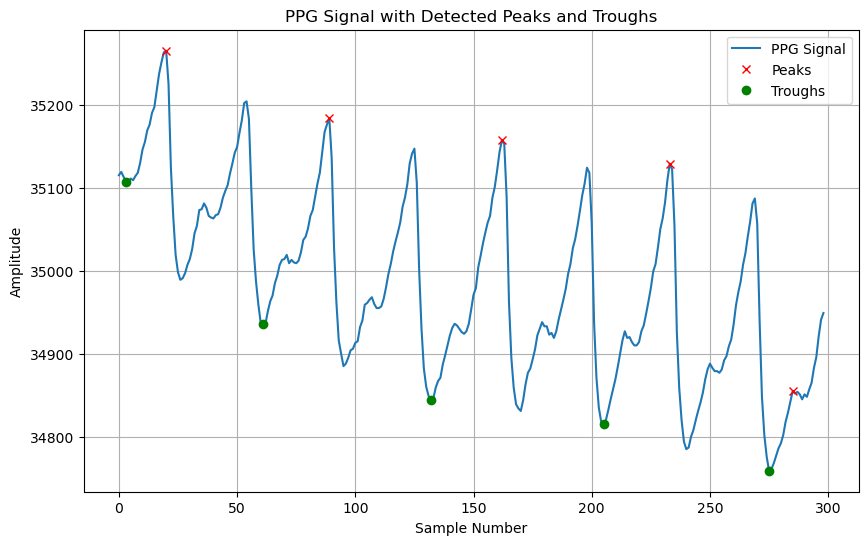

In [39]:
from scipy.signal import find_peaks

# Detect peaks 
peaks, _ = find_peaks(ppg_signal, distance=40)

# Detect troughs by inverting the signal
inverted_signal = -ppg_signal
troughs, _ = find_peaks(inverted_signal, distance=40)

# Plot the signal with peaks and troughs
plt.figure(figsize=(10, 6))
plt.plot(ppg_signal, label='PPG Signal')
# Plot peaks
plt.plot(peaks, ppg_signal[peaks], 'rx', label='Peaks')
# Plot troughs
plt.plot(troughs, ppg_signal[troughs], 'go', label='Troughs')

plt.title("PPG Signal with Detected Peaks and Troughs")
plt.xlabel("Sample Number")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()
